<a href="https://colab.research.google.com/github/tingard/kaggle-humpback-whales/blob/master/humpback_whales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Humpback whale competition, on Kaggle

In [1]:
!pwd
!pip install kaggle
!mkdir ~/.kaggle

/content
mkdir: cannot create directory ‘/root/.kaggle’: File exists


We need to authenticate kaggle - so set up the kaggle.json file (this is definitely not the most secure method)

In [0]:
import json
import getpass
import os
import pandas as pd
from IPython.display import Image
import numpy as np

In [3]:
if False:
  key = getpass.getpass('Paste API key here')
  token = {"username":"tingard","key": key}

  with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as file:
      json.dump(token, file)

  !chmod 600 ~/.kaggle/kaggle.json

Paste API key here··········


In [4]:
!mkdir train_images

mkdir: cannot create directory ‘train_images’: File exists


In [6]:
!kaggle competitions download -c humpback-whale-identification && unzip train.zip -d train_images > log.log

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
replace train_images/1cb7e70be.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
os.listdir('.')

['.config',
 'train_images',
 'train.zip',
 'sample_submission.csv',
 'train.csv',
 'test.zip',
 '.kaggle',
 'log.log',
 'sample_data']

### We have our data!

Let's have a look at it

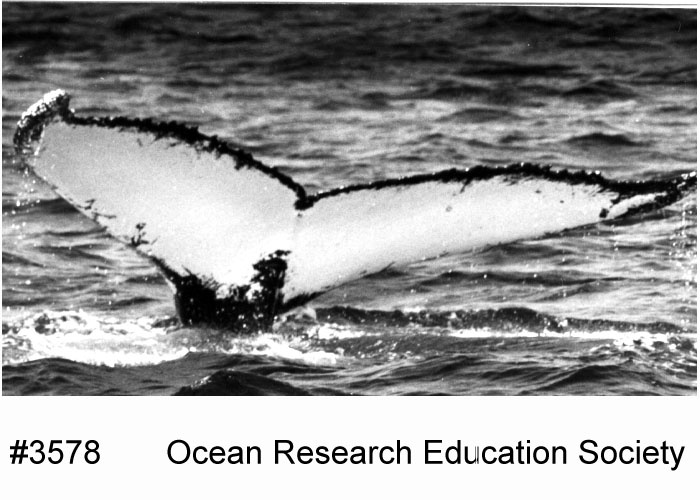

In [8]:
train_images = os.listdir('train_images')
Image(os.path.join('train_images', np.random.choice(train_images)))

In [19]:
sample_submission = pd.read_csv('sample_submission.csv')
training_set = pd.read_csv('train.csv')

ascending_groups = training_set.groupby('Id').count().sort_values(by='Image', ascending=False).head(10)
ascending_groups

,Image
Id,
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57
w_3de579a,54
w_564a34b,51
w_fd3e556,50


In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


# Approach:

Provide two grey-scale pictures of a whale to a neural network. The network returns if they are the same whale or not (similar to how facial recognition works on phones I guess).

After some more research - One shot learning (possibly with Siamese networks)

# Architecture
Simple conv2D and pooling setup for now. Can experiment with transfer learning on something bigger at a later date

---
Import modules:

In [0]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

Define our model

In [32]:
whales_to_use = ascending_groups.iloc[1:20].index
whales_to_use

Index(['w_23a388d', 'w_9b5109b', 'w_9c506f6', 'w_0369a5c', 'w_700ebb4',
       'w_3de579a', 'w_564a34b', 'w_fd3e556', 'w_88e4537'],
      dtype='object', name='Id')

In [0]:
mask = np.isin(training_set['Id'].values, whales_to_use)
training_set_filtered = training_set[mask]

In [44]:
training_set_filtered.shape

(522, 2)

Credit: https://sorenbouma.github.io/blog/oneshot/

In [14]:
input_shape = (128, 128, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

#merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)

#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

Epoch 1/10
100/100 [==============================] - 4s 41ms/step - loss: 2.3156
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 2.3163
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 2.3045
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 2.2764
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 2.2753
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 2.2527
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 2.2440
Epoch 8/10
100/100 [==============================] - 0s 2ms/step - loss: 2.2681
Epoch 9/10
100/100 [==============================] - 0s 2ms/step - loss: 2.2704
Epoch 10/10
20/20 [==============================] - 0s 7ms/step


In [15]:
print(score)

2.3707144260406494
